In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ['CUBLAS_WORKSPACE_CONFIG']=':4096:8'
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from tensorboardX import SummaryWriter

import numpy as np

from tqdm import tqdm
from tqdm import trange

# import math
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
        
        
def output_final(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_loss_inf = 0, 0


    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)

            test_loss += loss_fn(pred, y).item()
            test_loss_inf += torch.linalg.vector_norm(pred-y, ord = float('inf')).item()
    test_loss /= num_batches
    test_loss_inf /= num_batches



    return test_loss, test_loss_inf


In [ ]:
num_sample = 2000*32
num_train = int(num_sample*0.8)
num_test = int(num_sample*0.2)

adjust_scale = 0

loss_fn = nn.MSELoss()


width_vector = [10, 20, 40, 80, 160, 320]

width_vector_2 = width_vector


times_w = 1

times_n = 32

merge = 0.75

k_period = 5

batch_size = 128

parall_size = 10


result_matrix = np.zeros((len(width_vector), parall_size))
result_matrix_infty = np.zeros((len(width_vector), parall_size))

result_matrix_adj = np.zeros((len(width_vector_2), parall_size))
result_matrix_infty_adj = np.zeros((len(width_vector_2), parall_size))

In [ ]:
#generate test set
temp = torch.linspace(-1, 1, int(np.sqrt(num_test)))
x_1, x_2 = torch.meshgrid(temp, temp)

# for consistency of tensor sizes

X_1 = torch.unsqueeze(x_1.reshape(-1),1)
X_2 = torch.unsqueeze(x_2.reshape(-1),1)

x_test = torch.cat([X_1, X_2], dim=1)


y_test = torch.unsqueeze(- torch.sin(torch.pi * x_test[:, 0] * x_test[:, 1]), 1)

# create data loaders.
test_set = torch.utils.data.TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test_set, batch_size = num_test, shuffle=False)

y_test_plot = - torch.sin(torch.pi * x_1 * x_2)

/home/22040517r/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
i = 0

# for times_n in tqdm(para_vector):
for width in tqdm(width_vector):
    
    actual_width = times_w*(8*width)

    class NN(nn.Module):
        def __init__(self, layers=[2, actual_width, 1, 1]):
            # First initial the __init__ in nn.Module 
            super(NN, self).__init__()
            
            self.layer1 = nn.Linear(in_features=layers[0], out_features=layers[1])
            self.relu = nn.ReLU()
            self.layer2 = nn.Linear(in_features=layers[1], out_features=layers[2], bias=False)
            self.layer3 = nn.Linear(in_features=layers[2], out_features=layers[3], bias=True)



        def forward(self, x):
            unacti = self.layer1(x)
            hidden1 = self.relu(unacti)
            hidden2 = self.layer2(hidden1)
            logits = self.layer3(hidden2)

            return logits
        
        
        
    for j in range(parall_size):
        
        
        model = NN().to(device)
        
        adjust_scale = 0

        model.load_state_dict(torch.load('2D-'+str(times_n)+'Xweight-bs'+str(batch_size)+'-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-merge'+str(merge)+'-W'+str(width)+'-iter'+str(j)+'.pth'))
        
        [result_matrix[i, j], result_matrix_infty[i, j]] = output_final(test_dataloader, model, loss_fn)
        
        
        adjust_scale = 10
        
        model.load_state_dict(torch.load('2D-'+str(times_n)+'Xweight-bs'+str(batch_size)+'-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-merge'+str(merge)+'-W'+str(width)+'-iter'+str(j)+'.pth'))
        
        [result_matrix_adj[i, j], result_matrix_infty_adj[i, j]] = output_final(test_dataloader, model, loss_fn)
        
        
    i += 1    
        
  

100%|██████████| 6/6 [00:26<00:00,  4.43s/it]


In [5]:
# for function plotting
width = 40
j = 1
adjust_scale = 0

model = NN([2, width*8, 1, 1]).to(device)


model.load_state_dict(torch.load('2D-'+str(times_n)+'Xweight-bs'+str(batch_size)+'-k'+str(k_period)+'-adjust'+str(adjust_scale)+'-merge'+str(merge)+'-W'+str(width)+'-iter'+str(j)+'.pth'))
        
with torch.no_grad():
    
    X_test = x_test.to(device)
    Y_pred = model(X_test)

    y_pred = Y_pred.cpu().detach().numpy()

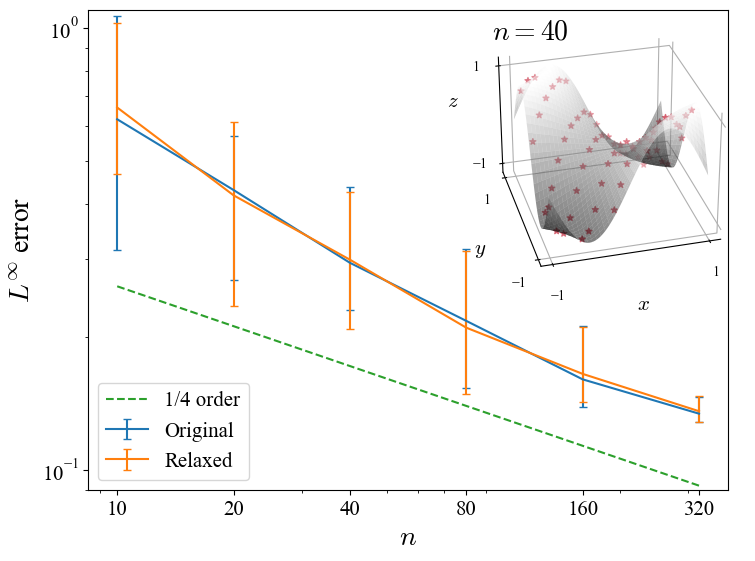

In [ ]:
from statistics import geometric_mean


import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'


x = width_vector


mean = np.zeros(int(len(x)))
mean_inf = np.zeros(int(len(x)))


for i in range(len(x)):
    mean[i] = geometric_mean(result_matrix[i])
    mean_inf[i] = geometric_mean(result_matrix_infty[i])


y_max = np.max(result_matrix, axis = 1)
y_min = np.min(result_matrix, axis = 1)

yerr = np.abs(np.vstack((y_min, y_max)) - mean)

y_max_inf = np.max(result_matrix_infty, axis = 1)
y_min_inf = np.min(result_matrix_infty, axis = 1)

yerr_inf = np.abs(np.vstack((y_min_inf, y_max_inf)) - mean_inf)



# with adjust

x2 = width_vector_2


mean2 = np.zeros(int(len(x2)))
mean_infty2 = np.zeros(int(len(x2)))


for i in range(len(x2)):
    mean2[i] = geometric_mean(result_matrix_adj[i])
    mean_infty2[i] = geometric_mean(result_matrix_infty_adj[i])


y_max2 = np.max(result_matrix_adj, axis = 1)
y_min2 = np.min(result_matrix_adj, axis = 1)

yerr2 = np.abs(np.vstack((y_min2, y_max2)) - mean2)

y_max_infty2 = np.max(result_matrix_infty_adj, axis = 1)
y_min_infty2 = np.min(result_matrix_infty_adj, axis = 1)

yerr_infty2 = np.abs(np.vstack((y_min_infty2, y_max_infty2)) - mean_infty2)






# for reference





fig=plt.figure(figsize=(8, 6))

l, b, w, h = 0.1, 0.1, 0.8, 0.8

ax1 = fig.add_axes([l, b, w, h])



plt.errorbar(x, mean_inf, yerr=yerr_inf, capsize = 3, label='Original')

plt.errorbar(x2, mean_infty2, yerr=yerr_infty2, capsize = 3, label='Relaxed')


begin_point = 2.6E-1

x_ref = [x[0], x[-1]]
y_ref = [begin_point, begin_point/np.power(np.power(2,len(x)), 1/4)]

plt.plot(x_ref, y_ref, linestyle='--', label='1/4 order')


plt.yscale('log')
plt.xscale('log')
plt.xlabel('$n$', size=20)
plt.ylabel('$L^\infty$ error', size=20)
plt.legend(fontsize=15, loc=(0.015, 0.02))
plt.xticks(x, x, fontsize=15)
plt.yticks(fontsize=15)

ax1.set_ylim(0.09, 1.1)


l, b, w, h = 0.51, 0.43, 0.47, 0.47
ax2=fig.add_axes([l, b, w, h], projection='3d', facecolor='none')

ax2.plot_surface(x_1, x_2, y_test_plot, zorder = 1, cmap='gist_gray', antialiased=True, shade=True, alpha = 0.5)


ax2.scatter(x_test[::200, 0], x_test[::200, 1], y_pred[::200],  marker="*", color = '#D25565', linestyle="None", zorder = 2)

ax2.set_xlabel('$x$', fontsize=15)
ax2.set_ylabel('$y$', fontsize=15)
ax2.set_zlabel('$z$', fontsize=15)

        
X = ax2.get_position().x0
Y = ax2.get_position().y1 
fig.text(X + 0.036, Y - 0.05, '$n = '+str(width)+'$', size=20)

ax2.set_xticks([-1, 1])

ax2.set_yticks([-1, 1])
ax2.set_zticks([-1, 1])

ax2.invert_xaxis()
ax2.invert_yaxis()


ax2.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax2.view_init(elev=30, azim=75) 


ax2.zaxis.set_rotate_label(False)




plt.savefig('plot.pdf', bbox_inches='tight')
plt.show()